# Задача регрессии

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    

Бизнес-задача: определить характеристики и с их помощью спрогнозировать длительность поездки такси.

Техническая задача: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

Основные цели проекта:
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных



### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from scipy.stats import normaltest

### Первичная обработка данных

In [2]:
# Прочитаем файл с исходными данными
taxi_data = pd.read_csv("data/train.csv")
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
# Посмотрим на временные рамки, в которых мы работаем с данными
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print(taxi_data['pickup_datetime'].max(), taxi_data['pickup_datetime'].min())

2016-06-30 23:59:39 2016-01-01 00:00:17


In [4]:
# Проверим датасет на наличие пропущенных значений
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [5]:
# Посмотрим статистические характеристики признаков
taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


### Feature Engineering

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Напишем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездкахи возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.


In [6]:
# Создаем функцию
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df

In [7]:
# Применим функцию к данным
add_datetime_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5


Напишем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 


In [8]:
# Прочитаем данные о праздничных днях
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date'])
taxi_data['pickup_date'] = pd.to_datetime(taxi_data['pickup_date'])

In [9]:
# Создадим функцию
def add_holiday_features(taxi, holiday):
    taxi = taxi.merge(holiday[['date']], how='left', left_on='pickup_date', right_on='date')
    taxi = taxi.fillna({'date':0})
    taxi['pickup_holiday'] = taxi['date'].apply(lambda x: 0 if x==0  else 1)
    taxi_new = taxi.drop(['date'], axis=1)
    return taxi_new

In [10]:
# Применим функцию к данным
taxi_data = add_holiday_features(taxi_data, holiday_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0


Напишем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.


In [11]:
# Прочитаем данные из OSRM
osrm_data = pd.read_csv('data/osrm_data_train.csv')

In [12]:
# Создадим функцию
def add_osrm_features(taxi, osrm):
    osrm_data = osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    taxi_new = taxi.join(osrm_data.set_index('id'), how='left', on='id')
    return taxi_new

In [13]:
# Применим функцию к данным
taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0


Напишем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Для этого предварительно напишем функции для рассчета расстояния по формуле Хаверсина и угла направления движения.

In [14]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [15]:
def add_geographical_features(data):
    data['haversine_distance'] = get_haversine_distance(
        data['pickup_latitude'], data['pickup_longitude'], 
        data['dropoff_latitude'], data['dropoff_longitude'])
    data['direction'] = get_angle_direction(
        data['pickup_latitude'], data['pickup_longitude'], 
        data['dropoff_latitude'], data['dropoff_longitude'])
    return data

In [16]:
# Применим функцию к данным
taxi_data = add_geographical_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0,1.188588,179.473585


Напишем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [17]:
# Создаем обучающую выборку из географических координат всех точек
coords = np.hstack((
    taxi_data[['pickup_latitude', 'pickup_longitude']],
    taxi_data[['dropoff_latitude', 'dropoff_longitude']]
    ))
# Обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=36)
kmeans.fit(coords)

KMeans(n_clusters=10, random_state=36)

In [18]:
# Создадим функцию
def add_cluster_features(data):
    coords = np.hstack((data[['pickup_latitude', 'pickup_longitude']],
                    data[['dropoff_latitude', 'dropoff_longitude']]))
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    data['geo_cluster'] = kmeans.labels_
    return data

In [20]:
# Применим функцию к данным
taxi_data = add_cluster_features(taxi_data)
taxi_data['geo_cluster'].value_counts()

0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

Напишем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.



In [21]:
# Прочитаем данные о погодных условиях и оставим нужные признаки
weather_data = pd.read_csv('data/weather_data.csv')
cols_to_drop = ['windchill', 'heat index', 'humidity', 'pressure', 'dew Point', 'wind dir', 'gust speed', 'conditions', 'time']
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data = weather_data.drop(cols_to_drop, axis=1)

In [22]:
# Создадим функцию
def add_weather_features(taxi, weather):
    taxi = taxi.merge(weather, how='left', left_on=['pickup_date', 'pickup_hour'], right_on=['date','hour'])
    data_new = taxi.drop(['date','hour'], axis=1)
    return data_new

In [23]:
# Применим функцию к данным
taxi_data = add_weather_features(taxi_data, weather_data)

Напишем функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполняем медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. 
Пропуски в столбце events заполняем строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 
Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполняем медианным значением по столбцам. 



In [24]:
# Создадим функцию
def fill_null_weather_data(data):
    grouped = data.groupby('pickup_date').median()
    values = {'temperature':grouped['temperature'].median(),\
                'visibility':grouped['visibility'].median(),\
                'wind speed':grouped['wind speed'].median(),\
                'precip':grouped['precip'].median(),\
                'events':'None',\
                'total_distance':data['total_distance'].median(),\
                'total_travel_time':data['total_travel_time'].median(),\
                'number_of_steps':data['number_of_steps'].median()}
    data_new = data.fillna(values)
    return data_new

In [25]:
# Применим функцию к данным
taxi_data = fill_null_weather_data(taxi_data)
taxi_data.isnull().sum()

C:\Users\Anna\AppData\Local\Temp\ipykernel_12480\3446683730.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = data.groupby('pickup_date').median()


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        0
total_travel_time     0
number_of_steps       0
haversine_distance    0
direction             0
geo_cluster           0
temperature           0
visibility            0
wind speed            0
precip                0
events                0
dtype: int64

Очистим датасет от выбросов по целевой переменной (длительность поездки)

Найдем слишком продолжительные поездки, длительность которых превышает 24 часа.
А также поездки со значительной средней скоростью (превышает 300 км/ч). Удалим эти выбросы.

Построим диаграмму рассеяния средней скорости движения автомобилей:


Text(0, 0.5, 'Average speed')

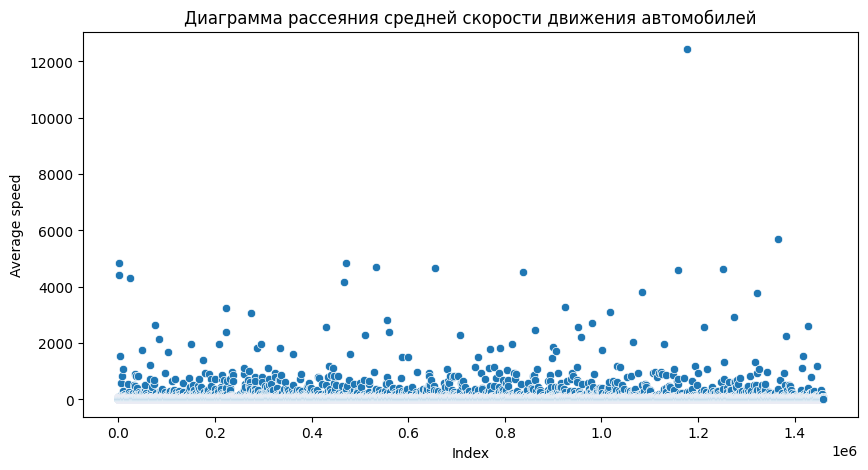

In [26]:
# Рассчитаем среднюю скорость поездки
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
# Построим график
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_title('Диаграмма рассеяния средней скорости движения автомобилей')
ax.set_xlabel('Index')
ax.set_ylabel('Average speed')

Напишем функции outliers_duration() для очищения датасета от выбросов по длительности и outliers_speed() - по скорости.

In [27]:
def outliers_duration(data, feature, limit):
    x = data[feature]/3600
    outliers = data[x>limit]
    data_new = data[x<=limit]
    return outliers, data_new

# Применим функцию к данным
out_d, taxi_data = outliers_duration(taxi_data, 'trip_duration', 24)

In [28]:
def outliers_speed(data, limit):
    x = data['total_distance'] / data['trip_duration'] * 3.6
    outliers = data[x>limit]
    cleaned = data[x<=limit]
    return outliers, cleaned

# Применим функцию к данным
out_s, taxi_data = outliers_speed(taxi_data, 300)

### Разведывательный анализ данных (EDA)

На этапе машинного обучения основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака.


In [29]:
# Логарифмируем целевой признак
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе для визуальной оценки распределения признака. А также проведем тест на нормальность Д’Агостино при уровне значимости 0.05 


Text(0.5, 0, 'Продолжительность поездки')

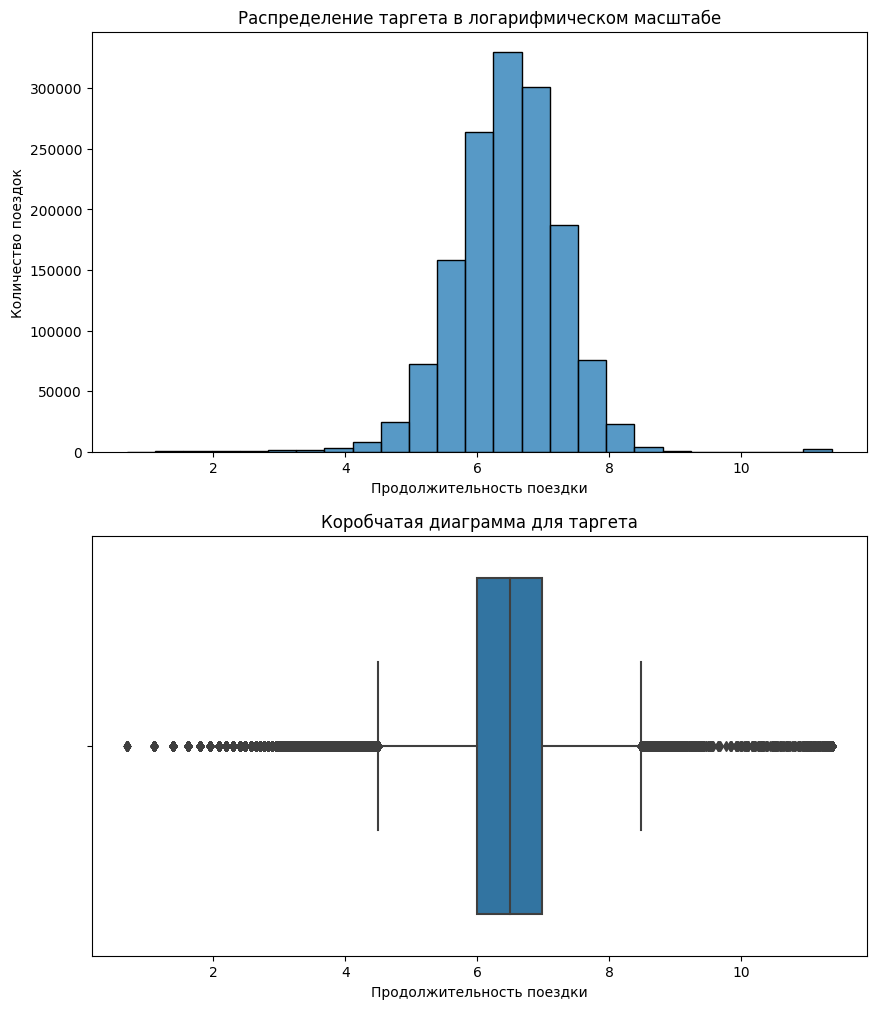

In [30]:
# Гистограмма и коробчатая диаграмма для целевого признака
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
sns.histplot(taxi_data, x='trip_duration_log', bins=25, ax=axes[0])
sns.boxplot(taxi_data, x='trip_duration_log', ax=axes[1])
axes[0].set_title('Распределение таргета в логарифмическом масштабе')
axes[0].set_xlabel('Продолжительность поездки')
axes[0].set_ylabel('Количество поездок')
axes[1].set_title('Коробчатая диаграмма для таргета')
axes[1].set_xlabel('Продолжительность поездки')

In [31]:
# тест Д’Агостино
# Формулируем гипотезы
H0 = 'Распределение целевого признака нормальное'
H1 = 'Распределение отлично от нормального'
# Уровень значимости
alpha = 0.05
stat, p = normaltest(taxi_data['trip_duration_log'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Проверяем гипотезы
if p > alpha:
	print('Невозможно опровергнуть нулевую гипотезу:', H0)
else:
	print('Отвергаем нулевую гипотезу:', H1)

Statistics=138350.166, p=0.000
Отвергаем нулевую гипотезу: Распределение отлично от нормального


Несмотря на то, что тест показал, что распределение целевого признака не является нормальным, судя по графику, к нормальному оно близко.
Построим гистограмму, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе в зависимости от таксопарка (vendor_id) и сравним их между собой.

Text(0, 0.5, 'Количество поездок')

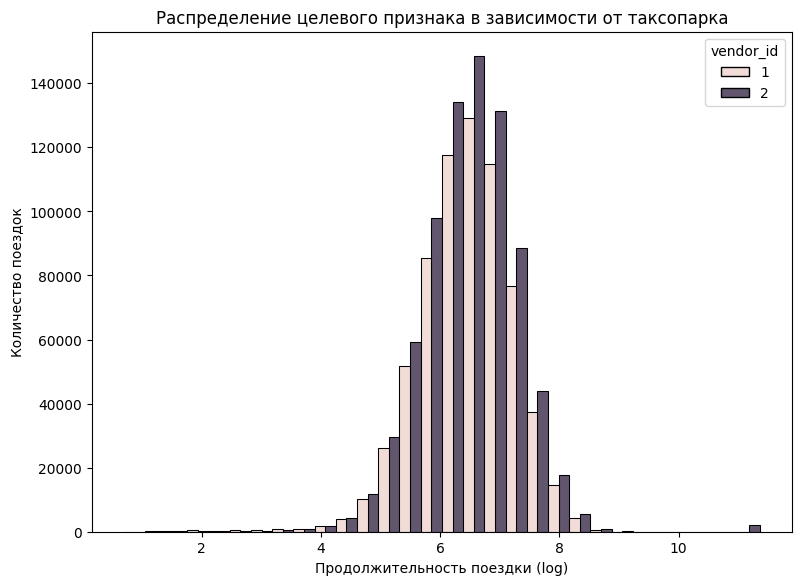

In [35]:
# Строим график
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes((1,1,1,1))
sns.histplot(taxi_data, x='trip_duration_log', hue='vendor_id', multiple='dodge', bins=30, ax=ax)
ax.set_title('Распределение целевого признака в зависимости от таксопарка')
ax.set_xlabel('Продолжительность поездки (log)')
ax.set_ylabel('Количество поездок')

На графике видно, что между различными таксопарками распределение продолжительности поездки существенно не отличается. Поэтому данный признак не оказывает существенного влияния на таргет

Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.


Text(0, 0.5, 'Количество поездок')

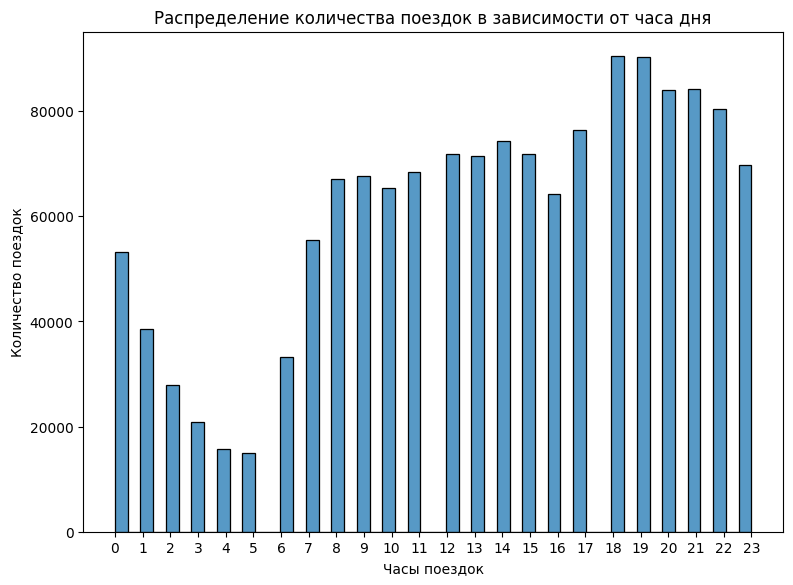

In [40]:
# Строим график
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes((1,1,1,1))
sns.histplot(taxi_data, x='pickup_hour', bins=50, ax=ax)
ax.set_xticks(list(range(0,24)))
ax.set_title('Распределение количества поездок в зависимости от часа дня')
ax.set_xlabel('Часы поездок')
ax.set_ylabel('Количество поездок')

Text(0, 0.5, 'Продолжительность поездки')

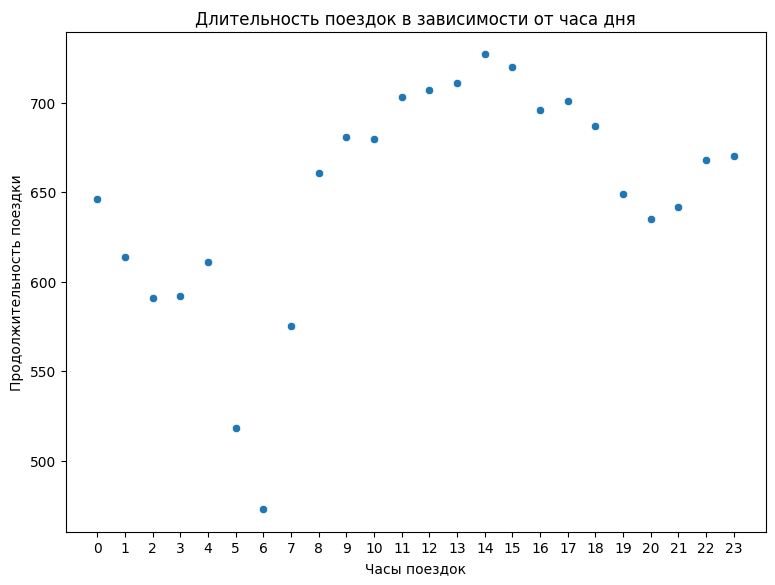

In [41]:
# Формируем выборку для визуализации
data = taxi_data[['pickup_hour', 'trip_duration']]
pivot = data.groupby('pickup_hour')['trip_duration'].median()
# Строим график
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes((1,1,1,1))
sns.scatterplot(pivot, ax=ax)
ax.set_xticks(list(range(0,24)))
ax.set_title('Длительность поездок в зависимости от часа дня')
ax.set_xlabel('Часы поездок')
ax.set_ylabel('Продолжительность поездки')


Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

Text(0, 0.5, 'Медианная длительность поездки')

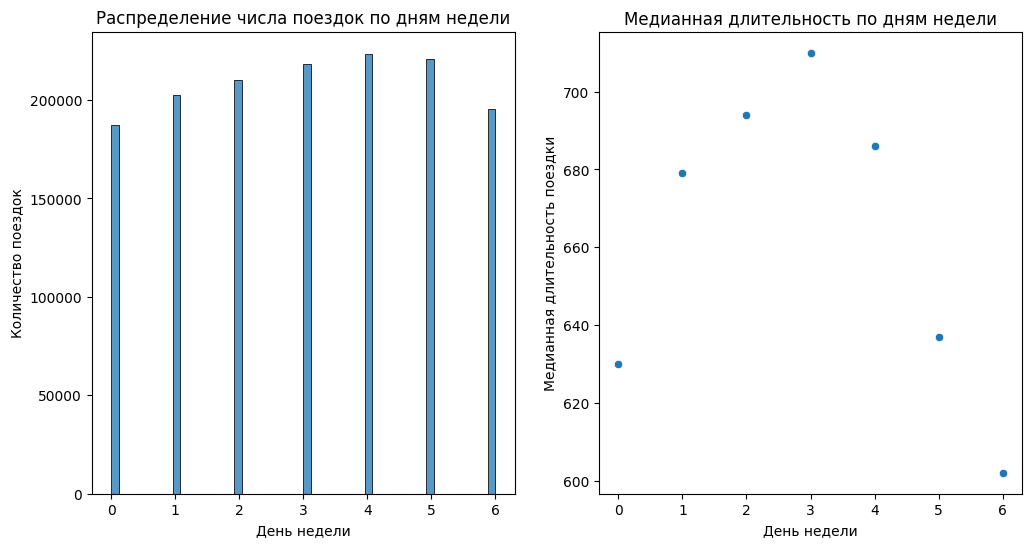

In [44]:
# Формируем выборку для визуализации
data = taxi_data[['pickup_day_of_week', 'trip_duration']]
pivot = data.groupby('pickup_day_of_week')['trip_duration'].median()
# Строим график
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
sns.histplot(taxi_data, x='pickup_day_of_week', bins=50, ax=axes[0])
sns.scatterplot(pivot, ax=axes[1])
axes[0].set_title('Распределение числа поездок по дням недели')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество поездок')
axes[1].set_title('Медианная длительность по дням недели')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Медианная длительность поездки')

Посмотрим на обе временные характеристики на одном графике. Построим сводную таблицу, по строкам которой отложены часы, по столбцам - дни недели, а в ячейках - медианная длительность поездки. Визуализируем полученную сводную таблицу с помощью тепловой карты.

Text(670.7222222222223, 0.5, 'Часы дня')

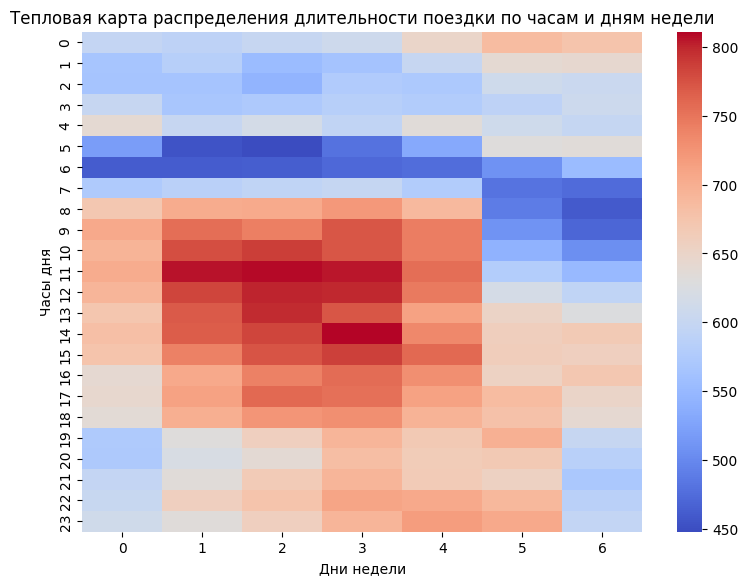

In [46]:
# Формируем сводную таблицу для визуализации
data = taxi_data[['pickup_hour', 'pickup_day_of_week', 'trip_duration']]
pivot = data.pivot_table(values='trip_duration', aggfunc='median', columns='pickup_day_of_week', index='pickup_hour')
# Строим график
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes((1,1,1,1))
sns.heatmap(pivot, cmap='coolwarm', ax=ax)
ax.set_title('Тепловая карта распределения длительности поездки по часам и дням недели')
ax.set_xlabel('Дни недели')
ax.set_ylabel('Часы дня')

### Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


Для удобства работы сделаем копию исходной таблицы с поездками:

In [47]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


4.1. Удалим неинформативный признак id и создающий утечку данных признак dropoff_datetime



In [48]:
train_data = train_data.drop(['id','dropoff_datetime'], axis=1)

Shape of data:  (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [49]:
train_data = train_data.drop(['pickup_datetime', 'pickup_date'], axis=1)

Shape of data:  (1458233, 23)


4.2. Закодируем признак vendor_ida таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируем признак store_and_fwd_flag таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.


In [50]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

0.53
0.006


4.3. Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и eventsс помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder получаем безымянный numpy-массив, который преобразуем обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder используем метод get_feature_names_out(). 


In [51]:
encoder = preprocessing.OneHotEncoder(drop='first')
columns_to_change = train_data[['pickup_day_of_week', 'geo_cluster', 'events']]

#кодируем данные
data_onehot = encoder.fit_transform(columns_to_change).toarray()
column_names = encoder.get_feature_names_out()

# формируем датафрейм
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
data_onehot.shape

(1458233, 18)

Добавим полученную таблицу с закодированными признаками:

In [52]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [53]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [54]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


4.4. С помощью SelectKBest отбираем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. 

In [55]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
feature_names = selector.get_feature_names_out()
feature_names

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_1',
       'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5',
       'pickup_day_of_week_6', 'geo_cluster_1', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

In [56]:
X_train = X_train[feature_names]
X_valid = X_valid[feature_names]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


4.5. Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. 

In [57]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

0.54

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [58]:
# ваш код здесь
def rmsle(y, y_pred):
    rmsle = metrics.mean_squared_error(y, y_pred)**0.5
    return rmsle

In [59]:
model = linear_model.LinearRegression()
model.fit(X_train_scaled, y_train_log)
y_pred_train = model.predict(X_train_scaled)
print(round(rmsle(y_train_log, y_pred_train), 2))
y_pred_valid = model.predict(X_valid_scaled)
print(round(rmsle(y_valid_log, y_pred_valid), 2))


0.54
0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [60]:
# ваш код здесь
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)
model = linear_model.LinearRegression()
model.fit(X_train_poly, y_train_log)
y_pred_train = model.predict(X_train_poly)
print(round(rmsle(y_train_log, y_pred_train), 2))
y_pred_valid = model.predict(X_valid_poly)
print(round(rmsle(y_valid_log, y_pred_valid), 2))

0.47
0.7


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [61]:
# ваш код здесь
model = linear_model.Ridge(alpha=1)
model.fit(X_train_poly, y_train_log)
y_pred_train = model.predict(X_train_poly)
print(round(rmsle(y_train_log, y_pred_train), 2))
y_pred_valid = model.predict(X_valid_poly)
print(round(rmsle(y_valid_log, y_pred_valid), 2))

0.48
0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [62]:
# ваш код здесь
model = tree.DecisionTreeRegressor()
model.fit(X_train_scaled, y_train_log)
y_pred_train = model.predict(X_train_scaled)
print(round(rmsle(y_train_log, y_pred_train), 2))
y_pred_valid = model.predict(X_valid_scaled)
print(round(rmsle(y_valid_log, y_pred_valid), 2))

0.0
0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [63]:
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  max_depth = trial.suggest_int('max_depth', 7, 20, 1)

  # создаем модель
  model = tree.DecisionTreeRegressor(max_depth=max_depth, random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train_log)
  score = rmsle(y_valid_log, model.predict(X_valid_scaled))

  return score

c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
study = optuna.create_study(study_name="DecisionTreeRegressor", direction="minimize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-06-13 12:53:22,374] A new study created in memory with name: DecisionTreeRegressor
[I 2023-06-13 12:53:37,841] Trial 0 finished with value: 0.44077767791251726 and parameters: {'max_depth': 8}. Best is trial 0 with value: 0.44077767791251726.
[I 2023-06-13 12:53:56,889] Trial 1 finished with value: 0.43319732848939047 and parameters: {'max_depth': 13}. Best is trial 1 with value: 0.43319732848939047.
[I 2023-06-13 12:54:16,678] Trial 2 finished with value: 0.43794314618447727 and parameters: {'max_depth': 14}. Best is trial 1 with value: 0.43319732848939047.
[I 2023-06-13 12:54:36,090] Trial 3 finished with value: 0.4298734650615536 and parameters: {'max_depth': 12}. Best is trial 3 with value: 0.4298734650615536.
[I 2023-06-13 12:55:03,049] Trial 4 finished with value: 0.4914438759570175 and parameters: {'max_depth': 20}. Best is trial 3 with value: 0.4298734650615536.
[I 2023-06-13 12:55:31,885] Trial 5 finished with value: 0.47196662859208155 and parameters: {'max_depth': 18

In [ ]:
print('best max depth:', study.best_params)
print('best score:', study.best_value)

In [ ]:
model = tree.DecisionTreeRegressor(random_state=42, max_depth=12)
model.fit(X_train_scaled, y_train_log)
y_pred_train = model.predict(X_train_scaled)
print(round(rmsle(y_train_log, y_pred_train), 2))
y_pred_valid = model.predict(X_valid_scaled)
print(round(rmsle(y_valid_log, y_pred_valid), 2))

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [65]:
# ваш код здесь
model = ensemble.RandomForestRegressor(n_estimators=200, max_depth=12, criterion='squared_error', min_samples_split=20, random_state=42, verbose=True)
model.fit(X_train_scaled, y_train_log)
y_pred_train = model.predict(X_train_scaled)
print(round(rmsle(y_train_log, y_pred_train), 2))
y_pred_valid = model.predict(X_valid_scaled)
print(round(rmsle(y_valid_log, y_pred_valid), 2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 43.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   27.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.4
0.41


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.6s finished


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [66]:
# ваш код здесь
GrBoo = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_split=30, random_state=42, verbose=True, learning_rate=0.5)
GrBoo.fit(X_train_scaled, y_train_log)
y_pred_train = GrBoo.predict(X_train_scaled)
print(round(rmsle(y_train_log, y_pred_train), 2))
y_pred_valid = GrBoo.predict(X_valid_scaled)
print(round(rmsle(y_valid_log, y_pred_valid), 2))

      Iter       Train Loss   Remaining Time 
         1           0.3110           15.94m
         2           0.2247           15.34m
         3           0.1987           14.93m
         4           0.1876           14.93m
         5           0.1823           14.89m
         6           0.1783           14.85m
         7           0.1749           14.63m
         8           0.1724           14.36m
         9           0.1710           14.23m
        10           0.1692           14.06m
        20           0.1576           13.15m
        30           0.1532           11.71m
        40           0.1498            9.95m
        50           0.1464            8.24m
        60           0.1448            6.51m
        70           0.1427            4.88m
        80           0.1409            3.25m
        90           0.1395            1.62m
       100           0.1380            0.00s
0.37
0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


<AxesSubplot: >

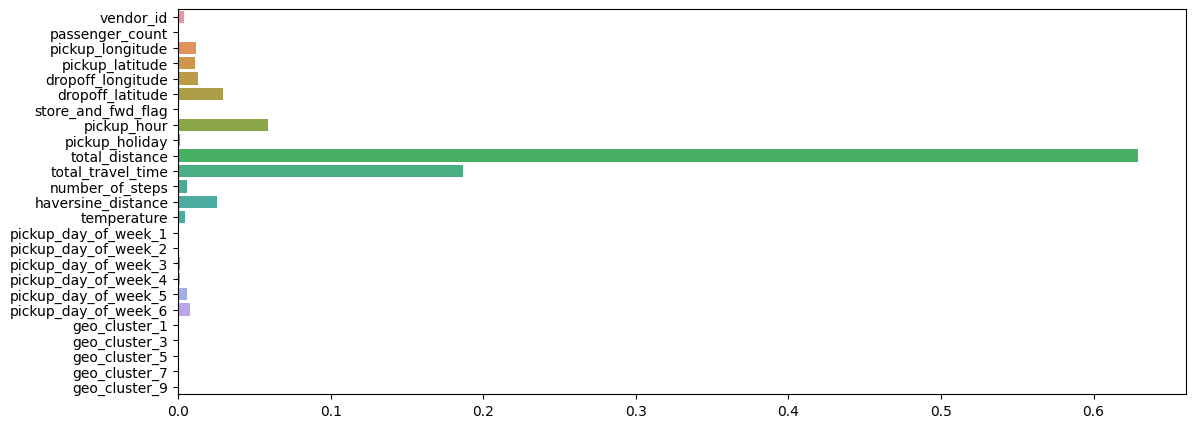

In [83]:
# ваш код здесь
fig, ax = plt.subplots(figsize=(13, 5))
feature = X_train.columns
feat_importances = GrBoo.feature_importances_
sns.barplot(y=feature, x=feat_importances, ax=ax, orient='h')

6.5. Для лучшей из построенных моделей (градиентный бустинг) рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$


In [86]:
y_pred_valid = GrBoo.predict(X_valid_scaled)
y_pred_valid = np.exp(y_pred_valid)-1
y_valid = np.exp(y_valid_log)-1
print(round(metrics.median_absolute_error(y_valid, y_pred_valid)/60, 1))

1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [103]:
test_data = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [94]:
osrm_data_test.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id0771704,6th Avenue,10th Avenue,1497.1,200.2,7,6th Avenue|West 17th Street|9th Avenue|9th Ave...,188.7|825.1|96.4|58.6|267.5|60.7|0,32.4|103.7|12.7|10.7|34|6.7|0,depart|turn|turn|continue|turn|turn|arrive,left|left|left|slight right|right|right|arrive,"-73.996527,40.737786|-73.995446,40.739272|-74...."
1,id3274209,5th Avenue,5th Avenue,1427.1,141.5,2,5th Avenue|5th Avenue,1427.1|0,141.5|0,depart|arrive,none|arrive,"-73.976974,40.75885|-73.98516,40.747618"
2,id2756455,East 18th Street,Park Avenue,2312.3,324.6,9,East 18th Street|Irving Place|East 19th Street...,19.3|74.1|148.9|632.1|163.9|1111.5|144.7|17.7|0,9.6|15.6|20.7|92.1|24.4|136.2|24.9|1.1|0,depart|turn|turn|turn|turn|turn|turn|turn|arrive,left|left|left|right|left|right|right|right|ar...,"-73.987161,40.736551|-73.986961,40.736466|-73...."
3,id3684027,Madison Avenue,6th Avenue,931.8,84.2,4,Madison Avenue|East 49th Street|6th Avenue|6th...,199.3|466.6|265.8|0,24.4|36.5|23.3|0,depart|turn|turn|arrive,right|left|right|arrive,"-73.977191,40.755664|-73.976045,40.757232|-73...."
4,id3101285,Madison Avenue,West 83rd Street,2501.7,294.7,8,Madison Avenue|East 91st Street|5th Avenue|86t...,31|154.9|491|907.6|272.1|248|397.2|0,9.4|29.7|46|103.6|25.1|21.8|59.1|0,depart|turn|turn|turn|new name|turn|turn|arrive,right|left|left|right|straight|left|right|arrive,"-73.956667,40.783797|-73.956489,40.784041|-73...."


In [95]:
test_data.head(
)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2016-03-14,23,3,0,3795.9,424.6,4,2.746426,-3.595224
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2016-06-12,23,3,0,2904.5,200.0,4,2.759239,172.278835
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,2016-01-19,23,3,0,1499.5,193.2,4,1.306155,133.326248
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,2016-04-06,23,3,0,7023.9,494.8,11,5.269088,-150.956833
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,2016-03-26,23,3,0,1108.2,103.2,4,0.960842,130.260381


In [104]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data['pickup_date'] = pd.to_datetime(taxi_data['pickup_date'])
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
columns_to_change = test_data[['pickup_day_of_week', 'geo_cluster', 'events']]
test_data_onehot = encoder.fit_transform(columns_to_change).toarray()
column_names = encoder.get_feature_names_out()
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[feature_names]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Anna\AppData\Local\Temp\ipykernel_4628\3213387376.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = data.groupby('pickup_date').median()


Shape of data: (625134, 25)


In [110]:
y_test_predict = GrBoo.predict(X_test)
y_test_predict = np.exp(y_test_predict)-1
y_test_predict

c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


array([  2844.55888713,   2844.55888713,   1927.0934672 , ...,
       226398.58375457, 226398.58375457, 154241.11450061])

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [111]:

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [112]:
!pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 8.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


После чего модуль можно импортировать:

In [113]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [115]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=feature_names)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=feature_names)
dtest = xgb.DMatrix(X_test_scaled, feature_names=feature_names)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [116]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93577	valid-rmse:1.93571
[20]	train-rmse:0.78496	valid-rmse:0.78585
[30]	train-rmse:0.47878	valid-rmse:0.48087
[40]	train-rmse:0.42112	valid-rmse:0.42386
[50]	train-rmse:0.40923	valid-rmse:0.41237
[60]	train-rmse:0.40427	valid-rmse:0.40782
[70]	train-rmse:0.40126	valid-rmse:0.40511
[80]	train-rmse:0.39932	valid-rmse:0.40349
[90]	train-rmse:0.39762	valid-rmse:0.40201
[100]	train-rmse:0.39593	valid-rmse:0.40063
[110]	train-rmse:0.39459	valid-rmse:0.39963
[120]	train-rmse:0.39349	valid-rmse:0.39875
[130]	train-rmse:0.39238	valid-rmse:0.39794
[140]	train-rmse:0.39129	valid-rmse:0.39732
[150]	train-rmse:0.39010	valid-rmse:0.39645
[160]	train-rmse:0.38940	valid-rmse:0.39601
[170]	train-rmse:0.38838	valid-rmse:0.39526
[180]	train-rmse:0.38769	valid-rmse:0.39490
[190]	train-rmse:0.38676	valid-rmse:0.39425
[200]	train-rmse:0.38608	valid-rmse:0.39387
[210]	train-rmse:0.38557	valid-rmse:0.39367
[220]	train-rmse:0.38478	valid-rmse:0.39328

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [117]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39076


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

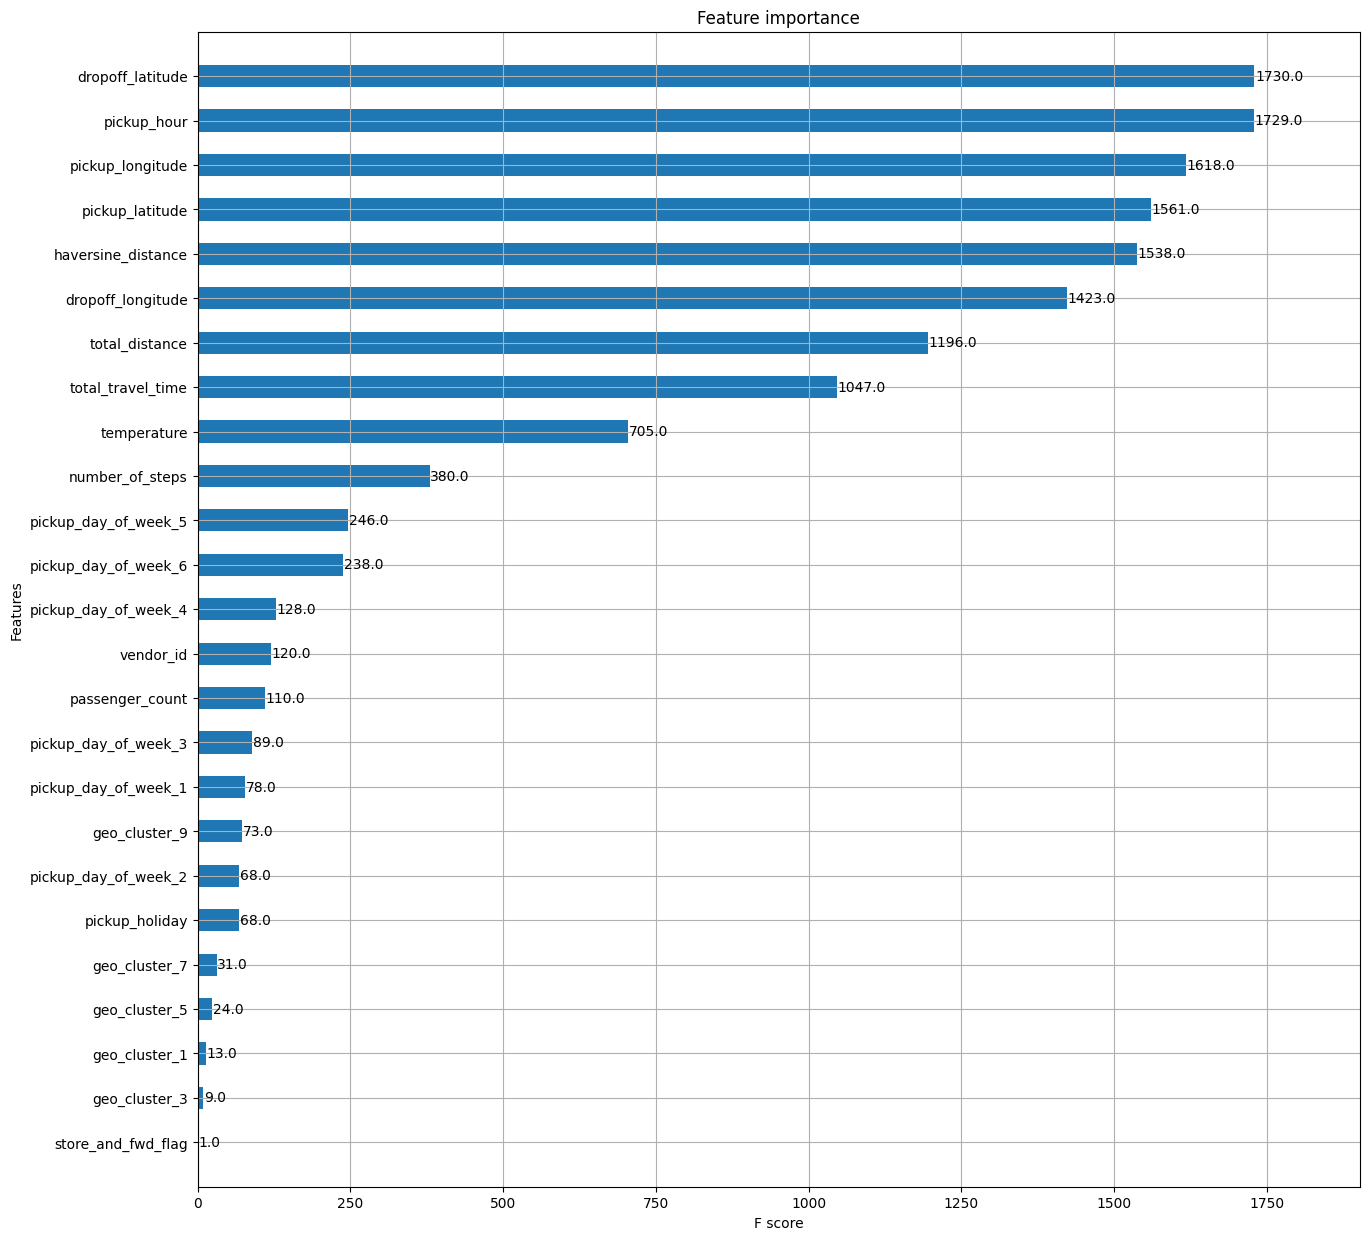

In [118]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)